# GZ: Builder spiral comparisons

First, set up the environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
from tempfile import NamedTemporaryFile
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from matplotlib.patches import Ellipse
from PIL import Image
from astropy.io import fits
from scipy.interpolate import splprep, splev, UnivariateSpline, interp1d
from scipy.ndimage.filters import gaussian_filter
from skimage import img_as_float
from skimage.transform import rotate, rescale
from skimage.measure import compare_ssim as ssim
import astropy.units as u
from gzbuilderspirals import deprojecting as dpj
from gzbuilderspirals import getDrawnArms, deprojectArm, rThetaFromXY, xyFromRTheta
from gzbuilderspirals.galaxySpirals import GalaxySpirals
import sdssCutoutGrab as scg
import createSubjectsFunctions as csf

In [3]:
print('Loading NSA catalog')
nsa = fits.open('../../subjectUpload/nsa_v1_0_1.fits')

nsa_keys = [
    'NSAID', 'ISDSS', 'INED', 'RA', 'DEC', 'Z', 'SERSIC_BA', 'SERSIC_PHI', 'PETRO_THETA',
    'IAUNAME', 'ZDIST', 'RUN', 'CAMCOL', 'FIELD', 'RERUN',
]
nsaRas = nsa[1].data['ra']
nsaDecs = nsa[1].data['dec']

df_nsa = pd.DataFrame(
    {key: nsa[1].data[key].byteswap().newbyteorder() for key in nsa_keys}
)

print('Loading Zooniverse classification dump')
classifications = pd.read_csv('../classifications/galaxy-builder-classifications_24-7-18.csv')
subjects = pd.read_csv('../classifications/galaxy-builder-subjects_24-7-18.csv')
null = None
true = True
false = False

print('Obtaining available frame montages')
# Some galaxies were montaged when created. Create a list of their coordinates for use later
montages = [f for f in os.listdir('montageOutputs') if not f[0] == '.']
montageCoordinates = np.array([
    [float(j) for j in i.replace('+', ' ').split(' ')]
    if '+' in i
    else [float(j) for j in i.replace('-', ' -').split(' ')]
    for i in [f for f in os.listdir('montageOutputs') if not f[0] == '.']
])

Loading NSA catalog
Loading Zooniverse classification dump
Obtaining available frame montages


In [4]:
subjectId = 20902039

Working on galaxy 20902039
	- USING MONTAGED IMAGE
	- Getting galaxy rotation
[createWCSObject] Checking for transformation
[createWCSObject] Using CD
	- Downloading Zooniverse image
	- Deprojecting image
	- Extracting spiral annotations
Done!


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/tlingard/PhD/gzbuilderspirals/gzbuilderspirals/deprojecting.py:24: RuntimeWarning: cdelt will be ignored since cd is present
  fits_cdelt = wFits.wcs.cdelt
/Users/tlingard/anaconda/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


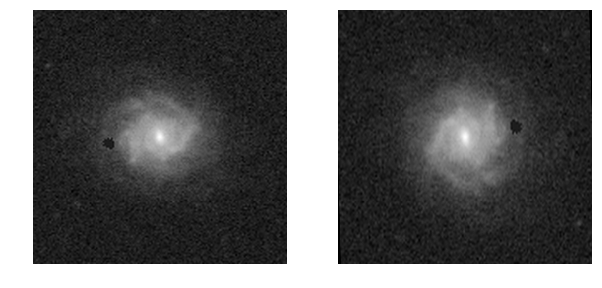

In [5]:
print('Working on galaxy {}'.format(subjectId))

# Grab the metadata of the subject we are working on
meta = eval(subjects[subjects['subject_id'] == subjectId].iloc[0]['metadata'])

# And the NSA data for the galaxy (if it's a galaxy with NSA data,
# otherwise throw an error)
try:
    gal = df_nsa[df_nsa['NSAID'] == int(meta['NSA id'])]
except KeyError:
    gal = {}
    raise KeyError('Metadata does not contain valid NSA id (probably an older galaxy)')

# Now we need to obtain the galaxy's rotation in Zooniverse image
# coordinates. This is made trickier by some decision in the subject
# creation pipeline.

# First, use a WCS object to obtain the rotation in pixel coordinates, as
# would be obtained from `fitsFile[0].data`

montagesDistanceMask = np.add.reduce(
    (montageCoordinates - [gal['RA'].iloc[0], gal['DEC'].iloc[0]])**2,
    axis=1
) < 0.01
usingMontage = np.any(montagesDistanceMask)
if usingMontage:
    montageFolder = montages[
        np.where(montagesDistanceMask)[0][0]
    ]
    fitsName = '{}/{}/{}'.format(
        os.path.abspath('montageOutputs'),
        montageFolder,
        'mosaic.fits'
    )
    print('\t- USING MONTAGED IMAGE')
else:
    fitsName = 'fitsImages/{0}/{1}/frame-r-{0:06d}-{1}-{2:04d}.fits'.format(
        int(gal['RUN']),
        int(gal['CAMCOL']),
        int(gal['FIELD'])
    )

print('\t- Getting galaxy rotation')
w = dpj.createWCSObject(gal, 512)
angle = dpj.getAngle(gal, fitsName, np.array([512, 512]))

print('\t- Downloading Zooniverse image')
# We'll now download the Zooniverse image that volunteers actually classified on
getUrl = lambda id: eval(subjects[subjects['subject_id'] == subjectId]['locations'].iloc[0])['1']
url = getUrl(subjectId)
imgData = requests.get(url).content

f = NamedTemporaryFile(suffix='.{}'.format(url.split('.')[-1]), delete=False)
f.write(imgData)
f.close()
pic = Image.open(f.name)
os.unlink(f.name)

# Grab the data arrays from the Image objects, and imshow the images (for debugging purposes)
picArray = np.array(pic)

print('\t- Deprojecting image')
# Now deproject the image of the galaxy:
rotatedImage = rotate(picArray, angle)
stretchedImage = rescale(
    rotatedImage,
    (1/gal['SERSIC_BA'].iloc[0], 1),
    mode='constant',
    multichannel=False
)
n = int((stretchedImage.shape[0] - np.array(pic).shape[0]) / 2)
if n > 0:
    deprojectedImage = stretchedImage[n:-n, :]
else:
    deprojectedImage = stretchedImage.copy()

print('\t- Extracting spiral annotations')

# Extract the drawn arms from classifications for this galaxy
drawnArms = getDrawnArms(subjectId, classifications)
print('Done!')

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(picArray, origin='lower', cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(deprojectedImage, origin='lower', cmap='gray')
plt.axis('off')
None

In [6]:
s = GalaxySpirals(drawnArms, ba=gal['SERSIC_BA'].iloc[0], phi=-angle)

# Now calculate a the distance matrix for the drawn arms (this can be slow)
try:
    distances = np.load('distances/subject-{}.npy'.format(subjectId))
    print('Using saved distances')
except OSError:
    print('Calculating distances')
    distances = s.calculateDistances()
    np.save('distances/subject-{}.npy'.format(subjectId), distances)

# Perform the clustering (using the DBSCAN clustering algorithm)
db = s.clusterLines(distances)

Using saved distances


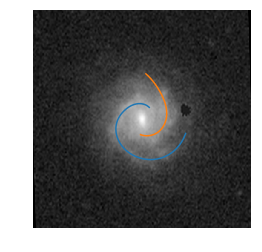

In [7]:
xyFits = s.fitXYSplines()
result = s.fitRadialSplines()

plt.imshow(deprojectedImage, cmap='gray', origin='lower')
for i, arm in enumerate(result['radialFit']):
    plt.plot(
        *s.arms[i].deNorm(arm).T
    )
plt.axis('off')
None

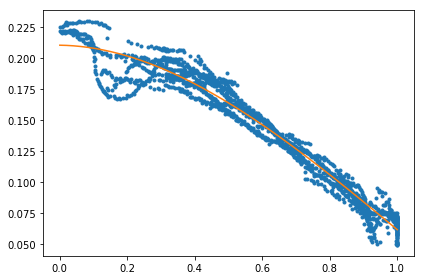

In [8]:
def fitSpline(deprojectedArm):
    sortingLine = deprojectedArm.getSortingLine()
    t = np.linspace(0, 1, sortingLine.shape[0])

    # order the arm along the deprojected XY fit
    o = deprojectedArm.orderAlongPolyLine(
        sortingLine
    )

    # calculate a strictly monotonic t array for points along this arm
    deprojectedT = deprojectedArm.genTFromOrdering(o)

    orderedDeprojectedCloud = (
        deprojectedArm.cleanedCloud[o['pointOrder']]
    )
    r_points, theta_points = rThetaFromXY(
        *deprojectedArm.normalise(orderedDeprojectedCloud).T,
        mux=0, muy=0
    )
    r_sorting, theta_sorting = rThetaFromXY(
        *(deprojectedArm.normalise(sortingLine).T)
    )

    thetaFunc = interp1d(t, theta_sorting)

    Sr = UnivariateSpline(deprojectedT, r_points / max(r_points), k=3)
    r_spline = Sr(t) * max(r_points)
    theta_spline = thetaFunc(t)
    xr, yr = xyFromRTheta(r_spline, theta_spline, mux=0, muy=0)

    return {
        'spline_x_y': np.stack((xr, yr), axis=1),
        'spline_r_theta': np.stack((r_spline, theta_spline), axis=1),
        'spline_t': t,
        'sortingLine': sortingLine,
        'points_r_theta': np.stack((r_points, theta_points), axis=1),
        'thetaFunc': thetaFunc,
        'points': deprojectedArm.normalise(deprojectedArm.cleanedCloud),
        'orderedDeprojectedCloud': orderedDeprojectedCloud,
        'deprojectedT': deprojectedT
    }
spline_fit_result = fitSpline(result['deprojectedArms'][0])
plt.plot(spline_fit_result['deprojectedT'], spline_fit_result['points_r_theta'][:, 0], '.')
plt.plot(spline_fit_result['spline_t'], spline_fit_result['spline_r_theta'][:, 0])
plt.tight_layout()

## Logarithmic spiral fit using Bayesian Ridge Regression

Now we have our ordered points in $(\theta, r)$, we can perform a linear bayesian ridge regression to obtain the log spiral.

Taking the log of the equation for a logarithmic spiral, we obtain
$$$
\log(r) = \log(a) + b\theta,
$$$

Therefore fitting a straight line to $\log(r)$ allows the recovery of $b$ as the gradient of the slope.

In [9]:
from sklearn.linear_model import BayesianRidge
br_clf = BayesianRidge(normalize=True)

In [10]:
def logSpiral(theta, a=1, b=1):
    return a * np.exp(b * theta)

# Get x and y given theta. Returns pairs of coordinates (N -> (N, 2))
def logSpiralXY(theta, a=1, b=1):
    return np.stack((
        a * np.cos(theta) * np.exp(b * theta),
        a * np.sin(theta) * np.exp(b * theta),
    ), axis=1)

In [11]:
r_points, theta_points = spline_fit_result['points_r_theta'].T

The data we'll fit to is these $(\theta, r)$ values, ordered by increasing theta

In [12]:
unwrapped_theta = np.unwrap(theta_points)
point_order_by_theta = np.argsort(unwrapped_theta)
Theta = unwrapped_theta[point_order_by_theta] + 2 * np.pi
r = r_points[point_order_by_theta]

Perform our fit to $\log(r)$

In [13]:
degree = 1
X_Theta = np.vander(Theta, degree+1)
br_clf.fit(X_Theta, np.log(r))
r_br_log_spiral_logged, r_br_log_spiral_std = br_clf.predict(X_Theta, return_std=True)
r_br_log_spiral = np.exp(r_br_log_spiral_logged)

Calculated pitch angle: 15.81°


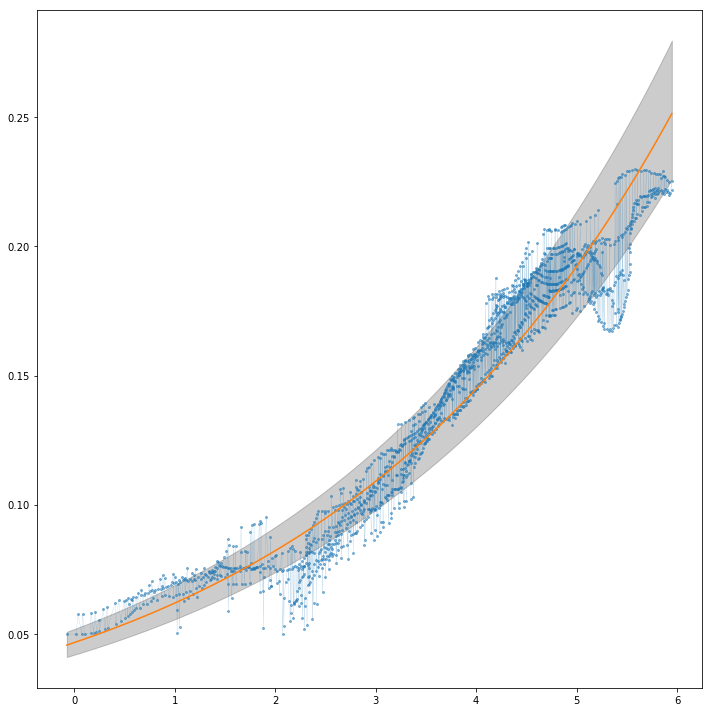

In [14]:
plt.figure(figsize=(10, 10))
plt.plot(Theta, r, '.-', markersize=4, linewidth=0.2, alpha=0.5)
plt.plot(Theta, r_br_log_spiral)
plt.fill_between(
    Theta,
    np.exp(r_br_log_spiral_logged - 1 * r_br_log_spiral_std),
    np.exp(r_br_log_spiral_logged + 1 * r_br_log_spiral_std),
    alpha=0.2, color='k'
)
plt.tight_layout()
print('Calculated pitch angle: {:.2f}°'.format(90 - np.rad2deg(np.arctan(1/br_clf.coef_[0]))))

## Spline fit using Bayesian Ridge Regression

As we wish to test whether a logarithmic spiral is an appropriate model for our galaxies, we will also perform a higher-order polynomial fit to $(t, r),$ using Bayesian Ridge Regression.

Note that $t$ is obtained through a point sorting method, and measures how far a point is along some "sorting line". It is monotonic with $\theta$ for a spiral which closely matches a logarithmic spiral.

In [15]:
T = spline_fit_result['deprojectedT']
T_predict = spline_fit_result['spline_t']
r = spline_fit_result['points_r_theta'][:, 0]

degree = 3
clf = BayesianRidge(normalize=True)
X = np.vander(T, degree+1)
X_predict = np.vander(spline_fit_result['spline_t'], degree+1)
clf.fit(X, r)
r_br, r_br_std = clf.predict(X_predict, return_std=True)
r_br.shape, r_br_std.shape

((500,), (500,))

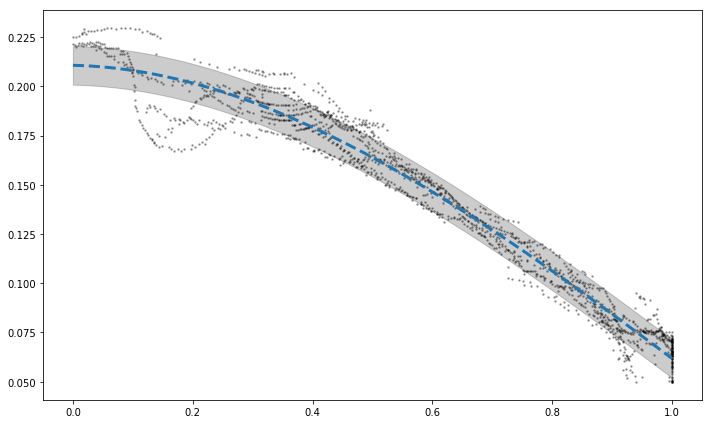

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(T, r, '.', c='k', alpha=0.3, markersize=3)
plt.fill_between(
    T_predict,
    r_br - 1 * r_br_std,
    r_br + 1 * r_br_std,
    alpha=0.2, color='k'
)
plt.plot(
    T_predict, r_br,
    '--', linewidth=3,
    label='Bayesian ridge regression'
)

plt.tight_layout()

In [31]:
from matplotlib.colors import to_rgb

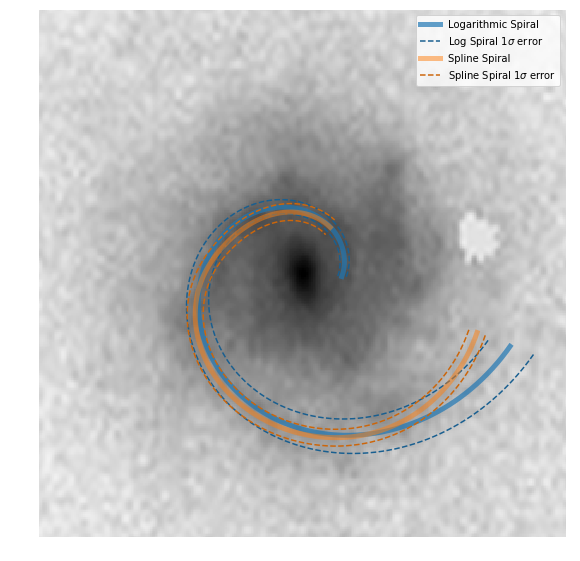

In [39]:
# get the points
theta_ = spline_fit_result['thetaFunc'](T_predict)

x_spline, y_spline = xyFromRTheta(r_br, theta_)
x_lower_spline, y_lower_spline = xyFromRTheta(r_br - r_br_std, theta_)
x_upper_spline, y_upper_spline = xyFromRTheta(r_br + r_br_std, theta_)

x_logarithmic_spiral, y_logarithmic_spiral = xyFromRTheta(r_br_log_spiral, Theta)
x_lower_logarithmic_spiral, y_lower_logarithmic_spiral = xyFromRTheta(r_br_log_spiral, Theta)

x_lower_logarithmic_spiral, y_lower_logarithmic_spiral = xyFromRTheta(
    np.exp(r_br_log_spiral_logged - 1 * r_br_log_spiral_std),
    Theta
)
x_upper_logarithmic_spiral, y_upper_logarithmic_spiral = xyFromRTheta(
    np.exp(r_br_log_spiral_logged + 1 * r_br_log_spiral_std),
    Theta
)

plt.figure(figsize=(8, 8))

# show the galaxy
plt.imshow(deprojectedImage, cmap='gray_r', origin='lower', extent=[-0.5, 0.5, -0.5, 0.5])

# plot the points
# for i, dpjArm in enumerate(result['deprojectedArms'][:1]):
#     points = dpjArm.normalise(dpjArm.cleanedCloud)
#     plt.plot(*points.T, '.', markersize=3, alpha=0.5)
    
# plot the log spiral and errors
p = plt.plot(x_logarithmic_spiral, y_logarithmic_spiral, linewidth=5, alpha=0.7, label='Logarithmic Spiral')
c = np.array(to_rgb(p[0].get_color())) * 0.8
plt.plot(
    x_lower_logarithmic_spiral, y_lower_logarithmic_spiral,
    '--', c=c,
    label='Log Spiral $1\sigma$ error'
)
plt.plot(x_upper_logarithmic_spiral, y_upper_logarithmic_spiral, '--', c=c)

# plot the spline and errors
p = plt.plot(x_spline, y_spline, linewidth=5, alpha=0.5, label='Spline Spiral')
c = np.array(to_rgb(p[0].get_color())) * 0.8
plt.plot(x_lower_spline, y_lower_spline, '--', c=c, label='Spline Spiral $1\sigma$ error')
plt.plot(x_upper_spline, y_upper_spline, '--', c=c)

plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.axis('off')
plt.legend()
plt.tight_layout()
None